In [1]:
import os
import glob
import json 
import random
from pathlib import Path
from difflib import SequenceMatcher
import shutil
from PIL import Image, ImageDraw, ImageFont
import cv2
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display
import matplotlib
from matplotlib import pyplot, patches


In [2]:
sroie_folder_path = Path('C:/Users/pawvaibh/Downloads/SROIE2019')
example_file = Path('X51005757324.txt')
image = Image.open(r'C:\Users\pawvaibh\Downloads\SROIE2019\0325updated.task1train(626p)\X51005757324.jpg')

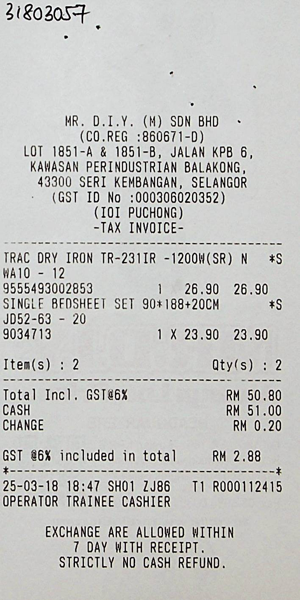

In [3]:
image = image.convert("RGB")
new_image = image.resize((300, 600))
new_image

In [4]:
def read_bbox_and_words(path: Path):
  bbox_and_words_list = []

  with open(path, 'r') as f:
    for line in f.read().splitlines():
      split_lines = line.split(",")

      bbox = np.array(split_lines[0:8], dtype=np.int32)
      text = ",".join(split_lines[8:])

      # From the splited line we save (filename, [bounding box points], text line).
      # The filename will be useful in the future
      bbox_and_words_list.append([path.stem, *bbox, text])
    
  dataframe = pd.DataFrame(bbox_and_words_list, columns=['filename', 'x0', 'y0', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'line'])
  dataframe = dataframe.drop(columns=['x1', 'y1', 'x3', 'y3'])

  return dataframe


# Example usage
bbox_file_path = sroie_folder_path / "0325updated.task1train(626p)" / example_file
print("== File content ==")
!type "{bbox_file_path}"

bbox = read_bbox_and_words(path=bbox_file_path)
print("\n== Dataframe ==\n")
bbox.head(5)

== File content ==
153,253,516,253,516,286,153,286,MR. D.I.Y. (M) SDN BHD
190,287,482,287,482,318,190,318,(CO. REG :860671-D)
56,321,596,321,596,354,56,354,LOT 1851-A & 1851-B, JALAN KPB 6 ,
70,355,579,355,579,388,70,388,KAWASAN PERINDUSTRIAN BALAKONG ,
88,389,583,389,583,418,88,418,43300 SERI KEMBANGAN, SELANGOR
124,424,532,424,532,455,124,455,(GST ID NO :000306020352)
222,455,432,455,432,486,222,486,(IOI PUCHONG)
220,490,434,490,434,518,220,518,-TAX INVOICE-
8,557,583,557,583,588,8,588,TRAC DRY IRON TR-231IR - 1200W(SR) N
632,559,669,559,669,586,632,586,*S
6,592,154,592,154,618,6,618,WA10 - 12
7,625,218,625,218,652,7,652,9555493002853
371,628,385,628,385,653,371,653,1
434,626,516,626,516,654,434,654,26.90
550,627,633,627,633,655,550,655,26.90
6,659,518,659,518,689,6,689,SINGLE BEDSHEET SET 90*188+20CM
634,660,667,660,667,688,634,688,*S
6,692,203,692,203,720,6,720,JD52-63 - 20
7,726,121,726,121,753,7,753,9034713
371,725,518,725,518,754,371,754,1 X 23.90
552,728,632,728,632,755,552,755

,filename,x0,y0,x2,y2,line
0,X51005757324,153,253,516,286,MR. D.I.Y. (M) SDN BHD
1,X51005757324,190,287,482,318,(CO. REG :860671-D)
2,X51005757324,56,321,596,354,"LOT 1851-A & 1851-B, JALAN KPB 6 ,"
3,X51005757324,70,355,579,388,"KAWASAN PERINDUSTRIAN BALAKONG ,"
4,X51005757324,88,389,583,418,"43300 SERI KEMBANGAN, SELANGOR"


In [5]:
def read_entities(path: Path):
  with open(path, 'r') as f:
    data = json.load(f)

  dataframe = pd.DataFrame([data])
  return dataframe


# Example usage
entities_file_path = sroie_folder_path / "0325updated.task2train(626p)" / example_file
print("== File content ==")
!type "{entities_file_path}"

entities = read_entities(path=entities_file_path)
print("\n\n== Dataframe ==")
entities

== File content ==
{
    "company": "MR. D.I.Y. (M) SDN BHD",
    "date": "25-03-18",
    "address": "LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR",
    "total": "50.80"
}


== Dataframe ==


,company,date,address,total
0,MR. D.I.Y. (M) SDN BHD,25-03-18,"LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERI...",50.80


In [6]:
def assign_line_label(line: str, entities: pd.DataFrame):
    line_set = line.replace(",", "").strip().split()
    for i, column in enumerate(entities):
        entity_values = entities.iloc[0, i].replace(",", "").strip()
        entity_set = entity_values.split()

        matches_count = 0
        for l in line_set:
          if any(SequenceMatcher(a=l, b=b).ratio() > 0.8 for b in entity_set):
            matches_count += 1

        if matches_count == len(line_set) or matches_count == len(entity_set):
            return column.upper()

    return "O"


line = bbox.loc[3,"line"]
label = assign_line_label(line, entities)
print("Line:", line)
print("Assigned label:", label)

Line: KAWASAN PERINDUSTRIAN BALAKONG ,
Assigned label: ADDRESS


In [7]:
def assign_labels(words: pd.DataFrame, entities: pd.DataFrame):
    max_area = {"TOTAL": (0, -1), "DATE": (0, -1)}  # Value, index
    already_labeled = {"TOTAL": False,
                       "DATE": False,
                       "ADDRESS": False,
                       "COMPANY": False,
                       "O": False
    }

    # Go through every line in $words and assign it a label
    labels = []
    for i, line in enumerate(words['line']):
        label = assign_line_label(line, entities)

        already_labeled[label] = True
        if label == "ADDRESS" and (already_labeled["DATE"] or already_labeled["TOTAL"]):
            label = "O"

        # Assign to the largest bounding box
        if label in ["TOTAL", "DATE"]:
            x0_loc = words.columns.get_loc("x0")
            bbox = words.iloc[i, x0_loc:x0_loc+4].to_list()
            area = (bbox[2] - bbox[0]) + (bbox[3] - bbox[1])

            if max_area[label][0] < area:
                max_area[label] = (area, i)

            label = "O"

        labels.append(label)

    labels[max_area["DATE"][1]] = "DATE"
    labels[max_area["TOTAL"][1]] = "TOTAL"

    words["label"] = labels
    return words


# Example usage
bbox_labeled = assign_labels(bbox, entities)
bbox_labeled.head(10)

,filename,x0,y0,x2,y2,line,label
0,X51005757324,153,253,516,286,MR. D.I.Y. (M) SDN BHD,COMPANY
1,X51005757324,190,287,482,318,(CO. REG :860671-D),O
2,X51005757324,56,321,596,354,"LOT 1851-A & 1851-B, JALAN KPB 6 ,",ADDRESS
3,X51005757324,70,355,579,388,"KAWASAN PERINDUSTRIAN BALAKONG ,",ADDRESS
4,X51005757324,88,389,583,418,"43300 SERI KEMBANGAN, SELANGOR",ADDRESS
5,X51005757324,124,424,532,455,(GST ID NO :000306020352),O
6,X51005757324,222,455,432,486,(IOI PUCHONG),O
7,X51005757324,220,490,434,518,-TAX INVOICE-,O
8,X51005757324,8,557,583,588,TRAC DRY IRON TR-231IR - 1200W(SR) N,O
9,X51005757324,632,559,669,586,*S,O


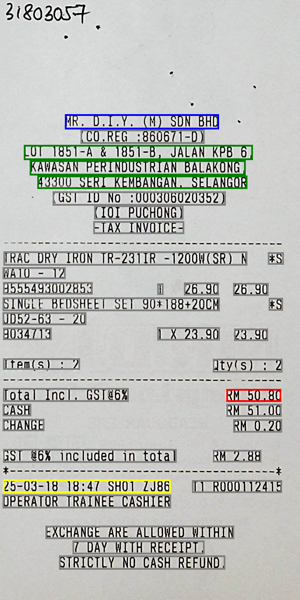

In [8]:
Color_labeled = {"TOTAL": "Red","DATE": "Yellow","ADDRESS": "Green","COMPANY": "Blue","O": "Gray"}

def Draw_BBox(image_path,_bbox_labeled: pd.DataFrame):
    actual_boxes = []
    for idx, row in _bbox_labeled.iterrows():
        x0 = row['x0']
        y0 = row['y0']
        x2 = row['x2']
        y2 = row['y2']
        label= row['label']
        color=Color_labeled[label]
        actual_box = [x0, y0, x2, y2] # we turn it into (left, top, left+width, top+height) to get the actual box 
        draw = ImageDraw.Draw(image, "RGB")
        draw.rectangle(actual_box, outline=color,width=4)
        new_image = image.resize((300, 600))
    return new_image

Draw_BBox(image,bbox_labeled)

In [9]:
def split_line(line: pd.Series):
  line_copy = line.copy()

  line_str = line_copy.loc["line"]
  words = line_str.split(" ")

  # Filter unwanted tokens
  words = [word for word in words if len(word) >= 1]

  x0, y0, x2, y2 = line_copy.loc[['x0', 'y0', 'x2', 'y2']]
  bbox_width = x2 - x0
  

  new_lines = []
  for index, word in enumerate(words):
    x2 = x0 + int(bbox_width * len(word)/len(line_str))
    line_copy.at['x0'] = x0
    line_copy.at['x2'] = x2
    line_copy.at['line'] = word
    new_lines.append(line_copy.to_list())
    x0 = x2 + 5 

  return new_lines



new_lines = split_line(bbox_labeled.loc[0])
print("Original row:")
display(bbox_labeled.loc[0:0,:])

print("Splitted row:")
pd.DataFrame(new_lines, columns=bbox_labeled.columns)

Original row:


,filename,x0,y0,x2,y2,line,label
0,X51005757324,153,253,516,286,MR. D.I.Y. (M) SDN BHD,COMPANY


Splitted row:


,filename,x0,y0,x2,y2,line,label
0,X51005757324,153,253,202,286,MR.,COMPANY
1,X51005757324,207,253,306,286,D.I.Y.,COMPANY
2,X51005757324,311,253,360,286,(M),COMPANY
3,X51005757324,365,253,414,286,SDN,COMPANY
4,X51005757324,419,253,468,286,BHD,COMPANY


In [10]:
from time import perf_counter
def dataset_creator(folder: Path, total=1000):
  bbox_folder = folder / '0325updated.task1train(626p)'
  entities_folder = folder / '0325updated.task2train(626p)'

  
  ignore = ['X51006619545.txt', 'X51006619785.txt', 'X51005663280(1).txt', 'X51005663280.txt'] 
  files = [file for file in bbox_folder.glob("*.txt") if file.name not in ignore]
  files = files[:total]

  data = []

  print("Reading dataset:")
  for file in tqdm(files, total=len(files)):
    bbox_file_path = file
    entities_file_path = entities_folder / file.name
    image_file_path = bbox_folder / file.with_suffix(".jpg")
  
    
    if not bbox_file_path.is_file() or not entities_file_path.is_file() or not image_file_path.is_file():
      continue
  
    
    bbox = read_bbox_and_words(bbox_file_path)
    entities = read_entities(entities_file_path)
    image = Image.open(image_file_path)

    
    bbox_labeled = assign_labels(bbox, entities)
    del bbox

    
    new_bbox_l = []
    for index, row in bbox_labeled.iterrows():
      new_bbox_l += split_line(row)
    new_bbox = pd.DataFrame(new_bbox_l, columns=bbox_labeled.columns)
    del bbox_labeled

 
    for index, row in new_bbox.iterrows():
      label = row['label']

      if label != "O":
        entity = entities.iloc[0, entities.columns.get_loc(label.lower())]
        if row['line'] not in entity:
          label = "O"
        else:
            
            label = "S-" + label
      
      new_bbox.at[index, 'label'] = label

    width, height = image.size
  
    data.append([new_bbox, width, height])

  return data


dataset = dataset_creator(sroie_folder_path)

Reading dataset:


  0%|          | 0/832 [00:00<?, ?it/s]

In [11]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


print("Train set size:", len(train_data))
print("Test set size:", len(test_data))

Train set size: 531
Test set size: 133


In [12]:
def create_dataset(dataset: list) -> dict:

    dataset_dict = {'text': [], 'bbox': [], 'image': []}

    def normalize(points: list, width: int, height: int) -> list:
        x0, y0, x2, y2 = [int(p) for p in points]
        
        x0 = int(1000 * (x0 / width))
        x2 = int(1000 * (x2 / width))
        y0 = int(1000 * (y0 / height))
        y2 = int(1000 * (y2 / height))

        return [x0, y0, x2, y2]

    for data, width, height in dataset:
        text_list = []
        bbox_list = []
        image_list = []

        for index, row in data.iterrows():
            text_list.append(row['line'])
            normalized_bbox = normalize([row['x0'], row['y0'], row['x2'], row['y2']], width, height)
            bbox_list.append(normalized_bbox)
            image_list.append([row['x0'], row['y0'], row['x2'], row['y2'], width, height, row['filename']])

        dataset_dict['text'].append(text_list)
        dataset_dict['bbox'].append(bbox_list)
        dataset_dict['image'].append(image_list)

    return dataset_dict

In [13]:
dataset_directory = Path('C:/Users/pawvaibh/Downloads/SROIE2019/working','dataset')

dataset_directory.mkdir(parents=True, exist_ok=True)

train_data = create_dataset(train_data)
test_data = create_dataset(test_data)

labels = ['COMPANY', 'DATE', 'ADDRESS', 'TOTAL']
IOB_tags = ['S']

label_list = []
for tag in IOB_tags:
    for label in labels:
        label_list.append(f"{tag}-{label}")
label_list.append("O")

In [15]:
from transformers import LayoutLMv2Tokenizer
tokenizer2 = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
label_file= label_list
dataset_dir="C:/Users/pawvaibh/Downloads/SROIE2019/working/dataset"


os.chdir("C:/Users/pawvaibh/Downloads/SROIE2019/working/unilm/layoutlm/deprecated/examples/seq_labeling")

print(os.getcwd())

C:\Users\pawvaibh\Downloads\SROIE2019\working\unilm\layoutlm\deprecated\examples\seq_labeling
